In [1]:
# %pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [2]:
# %pip install "gym==0.19.0"

In [3]:
# %pip install gym[all]

In [4]:
# %conda install -c conda-forge ta-lib

In [5]:
# %pip install yfinance

In [6]:
# %pip install protobuf==3.20.0

In [7]:
# %pip install stable-baselines3

In [8]:
# %pip install shimmy

In [9]:
# %pip install gymnasium

In [10]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import tensorflow as tf

In [11]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [12]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
# from gymnasium import GymEnvironment

# Stable baselines - rl stuff
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3 import A2C, DQN, TD3, DDPG
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C, DQN, TD3

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#Finance libraries
import datetime as dt
import talib as ta
import yfinance as yf

d:\Env\StockReinLearVenv\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [13]:
# Define trading parameters
ticker = "AAPL"
end_date = dt.datetime.now() - dt.timedelta(days=365 * 2)
start_date = end_date - dt.timedelta(days=365 * 5)
df = pd.DataFrame(yf.download(ticker, start_date, end_date))
df['SMA'] = ta.SMA(df['Close'])
df['EMA'] = ta.EMA(df['Close'])
df['RSI'] = ta.RSI(df['Close'])
df['MACD'], df['MACD_SIGNAL'], df['MACD_HIST'] = ta.MACD(df['Close'])
df['ADX'] = ta.ADX(df['High'], df['Low'], df['Close'])
df['OBV'] = ta.OBV(df['Close'], df['Volume'])
df['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'])

[*********************100%%**********************]  1 of 1 completed


In [14]:
df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
SMA            29
EMA            29
RSI            14
MACD           33
MACD_SIGNAL    33
MACD_HIST      33
ADX            27
OBV             0
ATR            14
dtype: int64

In [15]:
df = df.dropna()

In [16]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,SMA,EMA,RSI,MACD,MACD_SIGNAL,MACD_HIST,ADX,OBV,ATR
Date,,,,,,,,,,,,,,,
2016-11-03,27.745001,27.865000,27.387501,27.457500,25.586943,107730400,28.671833,28.543084,28.507008,-0.081239,0.238323,-0.319561,24.418879,37559600.0,0.451047
2016-11-04,27.132500,27.562500,27.027500,27.209999,25.356306,123348000,28.639583,28.457079,26.121605,-0.173511,0.155956,-0.329467,26.579735,-85788400.0,0.457043
2016-11-07,27.520000,27.627501,27.365000,27.602501,25.722069,130240000,28.619000,28.401945,35.359325,-0.212517,0.082261,-0.294778,28.375723,44451600.0,0.454219
2016-11-08,27.577499,27.930000,27.424999,27.764999,25.873493,97016800,28.602083,28.360852,38.772706,-0.227692,0.020271,-0.247963,29.098669,141468400.0,0.457846
2016-11-09,27.469999,27.830000,27.012501,27.719999,25.831562,236705600,28.576500,28.319506,38.171577,-0.240576,-0.031899,-0.208677,30.268548,-95237200.0,0.483536


In [17]:
df.shape

(1226, 15)

In [18]:
df.dtypes

Open           float64
High           float64
Low            float64
Close          float64
Adj Close      float64
Volume           int64
SMA            float64
EMA            float64
RSI            float64
MACD           float64
MACD_SIGNAL    float64
MACD_HIST      float64
ADX            float64
OBV            float64
ATR            float64
dtype: object

Stable baseline ile Gym SB3 ile Gymnasium

In [19]:
# Define the number of episodes for training
Time_Step = 1000000
models_dir = 'D:/Code/Stock/Python/Stock/models/A2C_1'
logdir = 'D:/Code/Stock/Python/Stock/logs/'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [20]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'EMA', 'RSI', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX', 'OBV', 'ATR']].to_numpy()[start:end]
    return prices, signal_features

In [21]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env_custom = MyCustomEnv(df=df, window_size=35, frame_bound=(35,1000))

In [22]:
env_maker = lambda: env_custom
env = DummyVecEnv([env_maker])

In [23]:
model = A2C('MlpLstmPolicy', env, verbose=1 ,tensorboard_log=logdir) # Stable Baseline ile

# model = TD3('MlpPolicy', env, verbose=1 ,tensorboard_log=logdir)

model.learn(total_timesteps=Time_Step)

---------------------------------
| explained_variance | 0.231    |
| fps                | 1        |
| nupdates           | 1        |
| policy_entropy     | 0.692    |
| total_timesteps    | 5        |
| value_loss         | 0.00209  |
---------------------------------
---------------------------------
| explained_variance | 0.00661  |
| fps                | 66       |
| nupdates           | 100      |
| policy_entropy     | 0.692    |
| total_timesteps    | 500      |
| value_loss         | 0.642    |
---------------------------------
---------------------------------
| explained_variance | -149     |
| fps                | 104      |
| nupdates           | 200      |
| policy_entropy     | 0.692    |
| total_timesteps    | 1000     |
| value_loss         | 0.000876 |
---------------------------------
---------------------------------
| explained_variance | 0.0358   |
| fps                | 116      |
| nupdates           | 300      |
| policy_entropy     | 0.691    |
| total_timest

In [24]:
env = MyCustomEnv(df=df, window_size=35, frame_bound=(1001,1226))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 23.729995727539062, 'total_profit': 1.1770517024664957, 'position': 1}


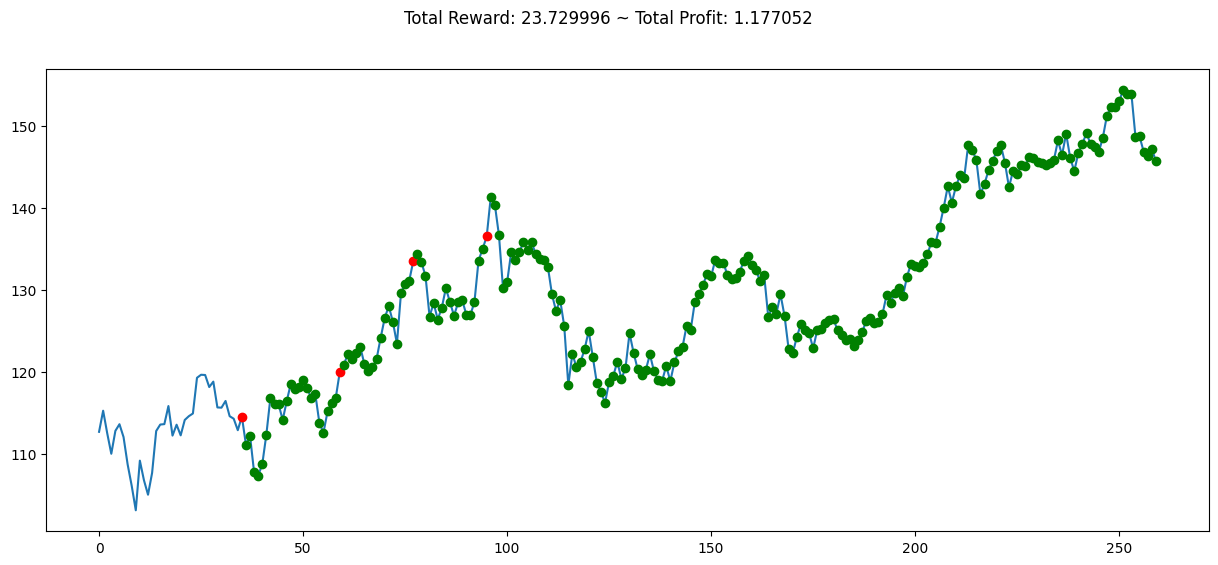

In [25]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()